In [1]:
# query 결과의 item들의 개수 구하기
# Select: Count를 설정했을 때와 그러지 않았을 때 속도 비교

In [2]:
import boto3
from boto3.dynamodb.conditions import Key, Attr
from time import time
import numpy as np
import matplotlib.pyplot as plt

dyn_resource = boto3.resource("dynamodb")
table_main_post = dyn_resource.Table("main_post-dev_cta_20221225-classu_ted")

In [3]:
# 기존 실제 DB에 있는 데이터 query

count_query = {
    "KeyConditionExpression": Key("channel_id").eq("93596c2c-7251-4e91-95af-6e95bd954a21")
        & Key("sk_post_order").begins_with("ACTIVE"),
    "IndexName": "channel_id-sk_post_order-index",
    "Select": "COUNT"
}

query = {
    "KeyConditionExpression": Key("channel_id").eq("93596c2c-7251-4e91-95af-6e95bd954a21")
        & Key("sk_post_order").begins_with("ACTIVE"),
    "IndexName": "channel_id-sk_post_order-index"
}

In [6]:
s1 = time()
table_main_post.query(**count_query)["Count"]
e1 = time()

s2 = time()
table_main_post.query(**query)["Count"]
e2 = time()

elapsed_time_1 = e1 - s1
elapsed_time_2 = e2 - s2

print(elapsed_time_1)
print(elapsed_time_2)

0.01959395408630371
0.017416954040527344


In [7]:
elapsed_time_1 = []
for i in range(100):
    s = time()
    table_main_post.query(**count_query)["Count"]
    e = time()
    
    elapsed_time = e - s
    elapsed_time_1.append(elapsed_time)
    
    
elapsed_time_2 = []
for i in range(100):
    s = time()
    table_main_post.query(**query)["Count"]
    e = time()
    
    elapsed_time = e - s
    elapsed_time_2.append(elapsed_time)

In [8]:
print(sum(elapsed_time_1)/100)
print(sum(elapsed_time_2)/100)

print(min(elapsed_time_1), max(elapsed_time_1))
print(min(elapsed_time_2), max(elapsed_time_2))

print(np.std(elapsed_time_1))
print(np.std(elapsed_time_2))

0.01323051929473877
0.01884371042251587
0.010354042053222656 0.026742935180664062
0.015084028244018555 0.0797278881072998
0.0031094255013051526
0.006606534612833182


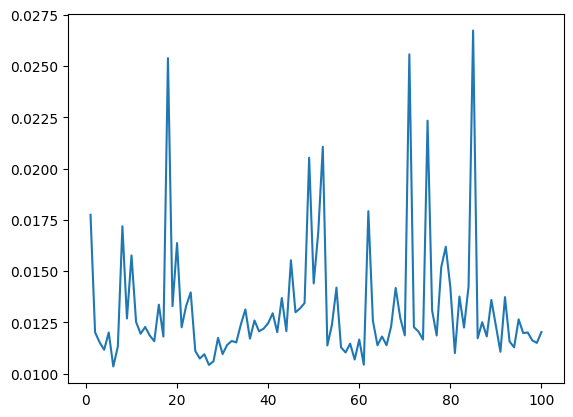

In [9]:
data_x = np.arange(1, 101)
data_y = np.array(elapsed_time_1)
plt.plot(data_x, data_y)
plt.show()

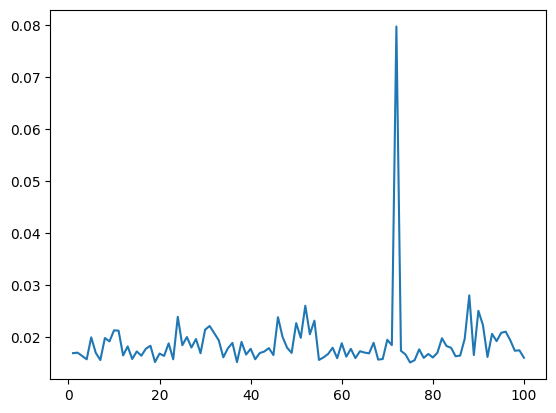

In [10]:
data_x = np.arange(1, 101)
data_y = np.array(elapsed_time_2)
plt.plot(data_x, data_y)
plt.show()

In [11]:
# main post item 1000개 삽입

main_post_list = [
    {
        "partition_key": f"main_post@count test main post {i}",
        "sort_key": "main_post",
        "main_post_id": f"count test main post {i}",
        "post_order": i,
        "channel_id": "count test channel",
        "sk_post_order": f"ACTIVE#{i:04d}"
    } for i in range(1, 1001)
]

with table_main_post.batch_writer() as writer:
    for main_post in main_post_list:
        writer.put_item(main_post)

In [12]:
count_query = {
    "KeyConditionExpression": Key("channel_id").eq("count test channel")
        & Key("sk_post_order").begins_with("ACTIVE"),
    "IndexName": "channel_id-sk_post_order-index",
    "Select": "COUNT"
}

query = {
    "KeyConditionExpression": Key("channel_id").eq("count test channel")
        & Key("sk_post_order").begins_with("ACTIVE"),
    "IndexName": "channel_id-sk_post_order-index"
}

In [13]:
print(table_main_post.query(**count_query)["Count"])
print(table_main_post.query(**query)["Count"])

1000
1000


In [14]:
elapsed_time_1 = []
for i in range(100):
    s = time()
    table_main_post.query(**count_query)["Count"]
    e = time()
    
    elapsed_time = e - s
    elapsed_time_1.append(elapsed_time)
    
elapsed_time_2 = []
for i in range(100):
    s = time()
    table_main_post.query(**query)["Count"]
    e = time()
    
    elapsed_time = e - s
    elapsed_time_2.append(elapsed_time)

In [15]:
print(sum(elapsed_time_1)/100)
print(sum(elapsed_time_2)/100)

print(min(elapsed_time_1), max(elapsed_time_1))
print(min(elapsed_time_2), max(elapsed_time_2))

print(np.std(elapsed_time_1))
print(np.std(elapsed_time_2))

0.02086907148361206
0.050645925998687745
0.01574230194091797 0.05092978477478027
0.04070019721984863 0.12077498435974121
0.0045287024889914705
0.010364749402581147


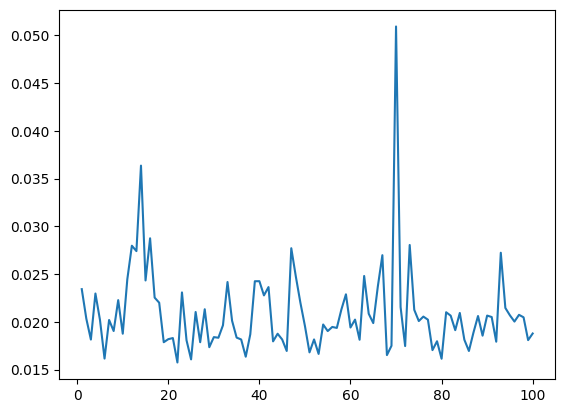

In [16]:
data_x = np.arange(1, 101)
data_y = np.array(elapsed_time_1)
plt.plot(data_x, data_y)
plt.show()

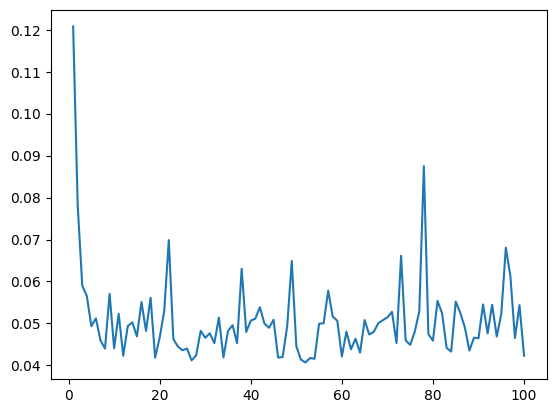

In [17]:
data_x = np.arange(1, 101)
data_y = np.array(elapsed_time_2)
plt.plot(data_x, data_y)
plt.show()

In [18]:
# Limit를 1로 했을 때 query 후, 특정 attribute 가져오는 속도

query = {
    "KeyConditionExpression": Key("channel_id").eq("count test channel")
        & Key("sk_post_order").begins_with("ACTIVE"),
    "IndexName": "channel_id-sk_post_order-index",
    "Limit": 1
}

In [19]:
elapsed_time_list = []
for i in range(100):
    s = time()
    table_main_post.query(**query)["Items"][0]["post_order"]
    e = time()
    
    elapsed_time = e - s
    elapsed_time_list.append(elapsed_time)

In [20]:
print(sum(elapsed_time_list)/100)
print(min(elapsed_time_list), max(elapsed_time_list))
print(np.std(elapsed_time_list))

0.015256283283233642
0.010162115097045898 0.024731159210205078
0.002814190537651815


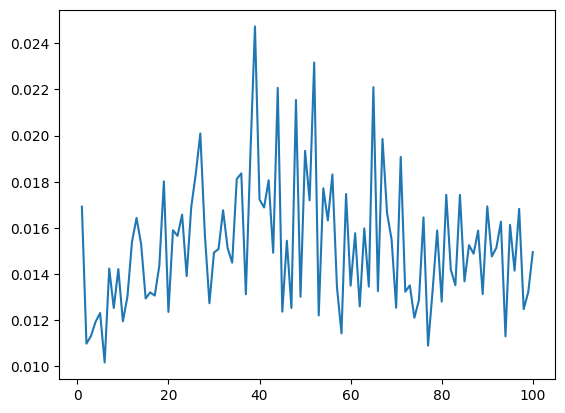

In [21]:
data_x = np.arange(1, 101)
data_y = np.array(elapsed_time_list)
plt.plot(data_x, data_y)
plt.show()

In [22]:
# 삽입한 데이터 삭제

with table_main_post.batch_writer() as batch:
    for primary_key_item in main_post_list:
        response = batch.delete_item(
            Key={
                "partition_key": primary_key_item["partition_key"],
                "sort_key": primary_key_item["sort_key"]
            }
        )